In [1]:
import pandas as pd

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')


In [2]:
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
# %load utils.py ## Using the command to load the scripts in functions.py into here for direction use
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [4]:
def process_data(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
        
    for col in ['Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex']:
        df = create_dummies(df, col)
    return df


In [5]:
train = process_data(train)
holdout = process_data(holdout)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [7]:
train[['SibSp', 'Parch']].describe()

,SibSp,Parch
count,891.000000,891.000000
mean,0.523008,0.381594
std,1.102743,0.806057
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,8.000000,6.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d641029e8>,
      dtype=object)

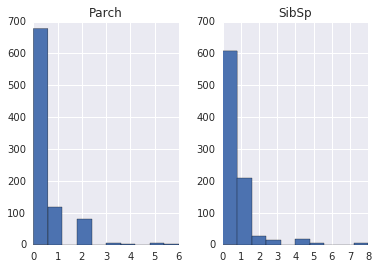

In [8]:
train[['SibSp', 'Parch']].hist()

In [9]:
train.pivot_table(values='Survived', index='SibSp', columns='Parch')

Parch,0,1,2,3,4,5,6
SibSp,,,,,,,
0,0.303538,0.657895,0.724138,1.000000,0.0,0.000000,NaN
1,0.520325,0.596491,0.631579,0.333333,0.0,0.333333,0.0
2,0.250000,0.857143,0.500000,1.000000,NaN,NaN,NaN
3,1.000000,0.000000,0.285714,NaN,NaN,NaN,NaN
4,NaN,0.000000,0.333333,NaN,NaN,NaN,NaN
5,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
8,NaN,NaN,0.000000,NaN,NaN,NaN,NaN


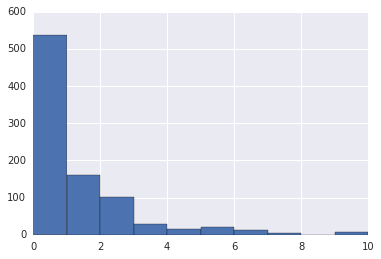

In [10]:
family = train['SibSp'] + train['Parch']
family.hist()

In [11]:
explore = train[['SibSp', 'Parch','Survived']].copy()
explore['family'] = explore[['SibSp', 'Parch']].sum(axis=1)


In [12]:
explore.pivot_table(index='family', values='Survived')

,Survived
family,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [13]:
def process_family(df):
    df['isalone'] = df.apply(lambda x: 1 if x['SibSp'] + x['Parch'] == 0 else 0, axis=1)
    return df

In [14]:
train = process_family(train)
holdout = process_family(holdout)

In [15]:
explore.columns

Index(['SibSp', 'Parch', 'Survived', 'family'], dtype='object')

In [16]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier


In [17]:
def select_features(df):
    
    df = df.select_dtypes('number')
    df.dropna(inplace=True)
    
    all_X = df.drop(['PassengerId', 'Survived'], axis=1)
    all_y = df['Survived']
    estimator = RandomForestClassifier(random_state=1)
    selector = RFECV(estimator, cv=10)
    selector.fit(all_X, all_y)
    print(all_X.columns[selector.support_])
    return all_X.columns[selector.support_]

    

In [18]:
select_cols = select_features(train)

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'isalone'],
      dtype='object')


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [21]:
def select_model(df, cols):
    all_X = df[cols]
    all_y = df['Survived']
    
    model_lists = [{
                    "name": "KNeighborsClassifier",
                    "estimator": KNeighborsClassifier(),
                    "hyperparameters":
                        {
                        "n_neighbors": range(1,20,2),
                        "weights": ["distance", "uniform"],
                        "algorithm": ["ball_tree", "kd_tree", "brute"],
                        "p": [1,2]
                        }
                    },
                    {
                    "name": "LogisticRegression",
                    "estimator": LogisticRegression(),
                    "hyperparameters":{"solver": ["newton-cg", "lbfgs", "liblinear"]}
                    },
                    {
                    "name": "RandomForestClassifier",
                    "estimator": RandomForestClassifier(),
                    "hyperparameters":
                        {
                        "n_estimators": [4, 6, 9],
                        "criterion": ["entropy", "gini"],
                        "max_depth": [2, 5, 10],
                        "max_features": ["log2", "sqrt"],
                        "min_samples_leaf": [1, 5, 8],
                        "min_samples_split": [2, 3, 5]
                        }
                    }
                    ]
    res = []
    for model in model_lists:
        print(model['name'])
        grid = GridSearchCV(model['estimator'], model['hyperparameters'])
        grid.fit(all_X, all_y)
        best_model = {'name': model['name'],
                      'best_estimator': grid.best_estimator_,
                     'best_params': grid.best_params_,
                     'best_score': grid.best_score_
                     }
        print(best_model['best_params'], best_model['best_score'])
        res.append(best_model)
    return res

In [22]:
best_models = select_model(train, select_cols)

KNeighborsClassifier
{'algorithm': 'brute', 'p': 1, 'weights': 'distance', 'n_neighbors': 15} 0.7609427609427609
LogisticRegression
{'solver': 'liblinear'} 0.8170594837261503
RandomForestClassifier
{'min_samples_split': 5, 'n_estimators': 4, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'entropy', 'max_features': 'log2'} 0.8395061728395061


In [23]:
def save_submission_file(model, cols, filename='titanic_pred.csv'):
    predictions = model.predict(holdout[cols])
    
    submission_df = {'PassengerId': holdout['PassengerId'], 'Survived': predictions}
    
    submission = pd.DataFrame(submission_df)
    submission.to_csv(filename)

In [25]:
save_submission_file(best_models[2]['best_estimator'], select_cols)

The best model here is the RandomForest which is better than LogisticRegression, the performs of the naive simple KNeighborsClassifier is worst.